Body size and range size relationship of avian scavengers
=================

**Macroecology Term Project**

Mitra Nikoo


## Table of contents

[1. Rationale and hypotheses](#1)

[2. Preamble](#2)

[3. Preliminary data exploration](#3)

[4. Analyses](#4)

&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Global avian scavengers](#4.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.1 Model plot](#4.1.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.2 Residuals distribution](#4.1.2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1.3 Outliers management](#4.1.3)

&nbsp;&nbsp;&nbsp;&nbsp;[4.2 Obligate and facultative scavengers](#4.2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.1 Model plot](#4.2.1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2.2 Residuals distribution](#4.2.2)

[5. Significance](#5)

[6. References](#6)

## A note on writing in Python

I use the style guide of [Flake8](https://pypi.org/project/flake8/), a linter similar to R's lintr, in conjunction with the code formatter, [Black](https://pypi.org/project/black/).
<!-- Black's formatting may not always look nice, but it will always be consistent. -->
<!-- Using a style guide is great, but using Black means that I do not have to think about how to refactor my code to meet the style guide. -->

I also adhere to the old Python adage, "explicit is better than implicit" ([The Zen of Python, 2004](https://peps.python.org/pep-0020/#the-zen-of-python)), written by one of the main software engineers behind the Python language, in how I name objects and variables.
Since you're not familiar with Python, I will also attempt to be explicit about my programming choices and when I am using functions that may seem odd or confusing to someone coming from an R background.

Lastly, Jupyter notebooks are not inherently accessible to screen readers, so code cells without rationale or other writing accompanying them will still include some sort of note for me to navigate the cells by.

-----------------

<a id='1'></a>
# 1. Rationale and hypotheses

The role of body size on species distribution has been a topic of continuous interest in macroecology, with the generally held trend that with greater body size also comes a larger range size (Brown and Maurer, 1989).
As the field matured, researchers examined this relationship at different spatial, taxonomic, and functional scales, identifying points at which this trend disintegrates [CITATION?].
This relationship may not be as straight forward with avian species, as small birds will have both small and large range sizes, which results in a more triangular shaped data distribution than a linear one when body size and range size (BSRS) are plotted together (Blackburn and Gaston, 1996).
These authors went on to suggest that this triangular distribution may not hold true within taxa and there will instead be no clear and consistent BSRS relationship in avian species.
However, Blackburn and Gaston (1996) only examined New World species, therefore we aim to examine the BSRS relationship at both a global scope and smaller taxonomic scales.

We will examine two taxonomic scales, the first on global avian scavengers as a single group, and the second by splitting the larger group into obligate scavengers and facultative scavengers.
Obligate species will be defined as birds who feed exclusively on carrion, and we will select facultative scavengers by species in which carrion feeding is a commonly described foraging behaviour (BirdLife International, 2024).
Obligate scavengers tend to be large-bodied birds (Ferguson-Lees, 2005), which we anticipate will have an effect on the BSRS trend for both objectives.
<!-- Information on weights will be provided by Raptors of the World (Ferguson-Lees, 2005). -->

## Hypothesis 1:
Our first objective seeks to identify a BSRS relationship across global avian scavengers and whether body size can be a predictor of the extent of occurrence (EOO) of a scavenger species. We expect to see a slightly negative relationship due to the number of obligate scavengers dominating the large body size classes that have small EOOs, because the extremeness of the large body size paired with the small EOOs of those obligate species may be enough to affect the linear relationship across all species, contrary to the expected relationship between bigger body sizes and larger EOOs (Brown and Maurer, 1989). 

## Hypothesis 2:

Our second objective asks whether there is a difference in the BSRS relationship between obligate and facultative scavengers. We anticipate that separating the obligate and facultative scavengers into their own groups will reveal different BSRS relationships. The range size of obligate scavengers will be limited by body size, because they are so large they must remain in geographic areas that facilitate flight, such as the Andean condor living in exclusively mountainous regions with strong updrafts. Therefore, we expect to see a negative relationship between BS and RS. However, facultative scavengers may show a positive body size-range size relationship that more closely matches the expectations outlined by Brown and Maurer (1989), because we are considering so many more species with a greater variability in body sizes; refer to that paper that showed mammals with bigger body sizes are kinda ecologically required to have larger ranges.

<a id='2'></a>
# 2. Preamble

Import libraries and set global options.

In [106]:
import pandas as pd  # For manipulating data structures
import numpy as np  # For mathematical functions
import scipy.stats as stats  # Algorithms and convenience functions built on NumPy
import statsmodels.api as sm  # For statistical methods
import statsmodels.formula.api as smf  # For writing formulas
import matplotlib.pyplot as plt  # Essentially the Python equivalent to ggplot2
import seaborn as sns  # A library for statistical graphics built on Matplotlib

# Global plot parameters
sns.set_theme(
    context="notebook",
    palette="colorblind",
)

# ANSI escape code for bold text in f strings
bold_start = "\033[1m"
bold_end = "\033[0m"

Read the data, excluding the columns Cara and I used for bookkeeping. I will index by species names rather than by row numbers to make working with the DataFrame more intuitive.

In [3]:
columns = [
    "Species name",
    "Scientific name",
    "Diet",
    "Extent of occurrence",
    "Body size",
]

scavengers = pd.read_csv(
    "../data/MacroEco scavenger data.csv", usecols=columns, index_col="Species name"
)
scavengers.head()

,Scientific name,Diet,Extent of occurrence,Body size
Species name,,,,
Black vulture,Coragyps atratus,Obligate,42593865.0,2200
Turkey vulture,Cathartes aura,Obligate,52285085.0,2500
Lesser yellow headed vulture,Cathartes burrovianus,Obligate,19989926.0,950
Greater yellow headed vulture,Cathartes melambrotus,Obligate,7481821.0,1650
King vulture,Sarcoramphus papa,Obligate,17390218.0,3800


Find and display any rows that have `NaN` (Not a Number) values.

In [4]:
scavengers.loc[scavengers.isnull().any(axis=1)]

,Scientific name,Diet,Extent of occurrence,Body size
Species name,,,,


BirdLife currently lists no data for the extent of occurrence (EOO) for the hooded crow, so let's drop it from our dataset.

In [5]:
scavengers.drop(["Hooded crow"], inplace=True)

Let's add new columns that have the log-transformed values for EOO and body size. We will use the base 10 system, because we are dealing with spatial ranges and it is easier to interpret distances in $log_{10}$ than the natural log, which uses base $e$.

In [6]:
scavengers["log Extent of occurrence"] = np.log10(scavengers["Extent of occurrence"])
scavengers["log Body size"] = np.log10(scavengers["Body size"])

scavengers.head()

,Scientific name,Diet,Extent of occurrence,Body size,log Extent of occurrence,log Body size
Species name,,,,,,
Black vulture,Coragyps atratus,Obligate,42593865.0,2200,7.629347,3.342423
Turkey vulture,Cathartes aura,Obligate,52285085.0,2500,7.718378,3.397940
Lesser yellow headed vulture,Cathartes burrovianus,Obligate,19989926.0,950,7.300811,2.977724
Greater yellow headed vulture,Cathartes melambrotus,Obligate,7481821.0,1650,6.874007,3.217484
King vulture,Sarcoramphus papa,Obligate,17390218.0,3800,7.240305,3.579784


Let's also make separate DataFrames for obligate and scavenger species.

In [7]:
obligates = scavengers.loc[scavengers["Diet"] == "Obligate"]
facultatives = scavengers.loc[scavengers["Diet"] == "Facultative"]

<a id='3'></a>
# 3. Preliminary data exploration

When we look at the raw data, we see that small birds can have both small and large EOOs, but that EOO tends to be smaller as body size increases. It also appears that there may be more of an exponential relationship than a linear one, so logarithms would be useful here.

Plotting the data on a $log_{10}$ scale shows signs that scavengers as a whole do not seem to have a relationship between EOO and body size.
When we consider obligates, however, there does seem to potentially be a negative linear relationship where larger obligate scavengers will have smaller range sizes. Facultative scavengers continue to seemingly not have a strong relationship between body size and range size, and/or have outliers.

Blackburn and Gaston (1996) suggest that a square root transformation for an area variable such as EOO might make more sense, but at the expense of comparing results with previous research.
Since that is part of what Cara and I are doing, we will also not square root transform the EOO.

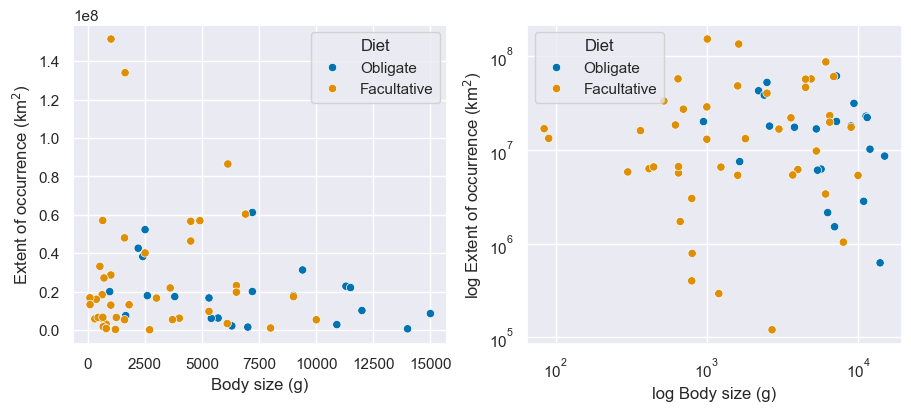

In [107]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(9,4), layout="constrained")

sns.scatterplot(
    ax=ax1,
    data=scavengers,
    x="Body size",
    y="Extent of occurrence",
    hue="Diet",
)
sns.scatterplot(
    ax=ax2,
    data=scavengers,
    x="Body size",
    y="Extent of occurrence",
    hue="Diet",
)
ax1.set_ylabel("Extent of occurrence (km$^2$)")
ax1.set_xlabel("Body size (g)")
ax2.set_ylabel("log Extent of occurrence (km$^2$)")
ax2.set_xlabel("log Body size (g)")

ax2.set_yscale("log")
ax2.set_xscale("log")

plt.show()

## Distribution

Disclaimer: I used Copilot for help refactoring the following code block when my for loops kept failing to combine the raw and log-transformed data.

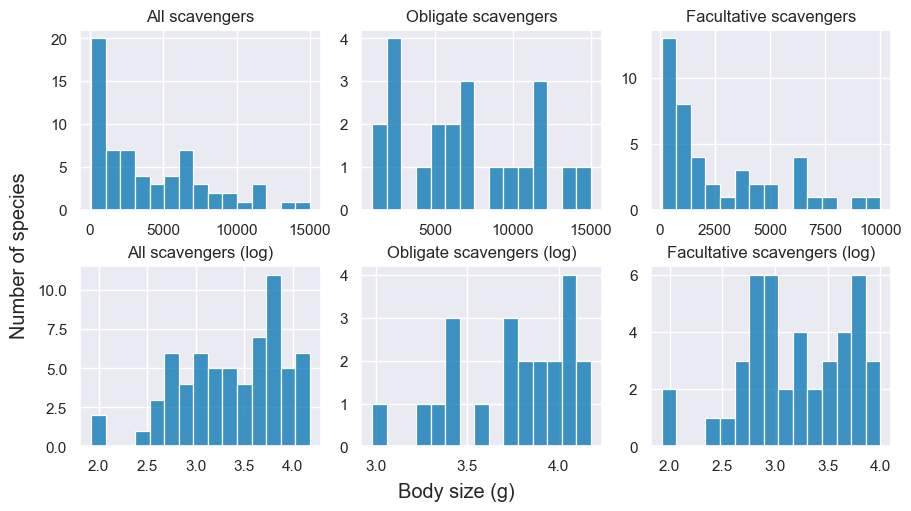

In [108]:
fig, axes = plt.subplots(2, 3, figsize=(9, 5), layout="constrained")

data = [scavengers, obligates, facultatives]
titles = ["All scavengers", "Obligate scavengers", "Facultative scavengers"]

# Plot the first row of histograms with raw data
for ax, d, title in zip(axes[0], data, titles):
    sns.histplot(ax=ax, data=d, x=d["Body size"], bins=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title)

# Plot the second row with log-transformed data
for ax, d, title in zip(axes[1], data, titles):
    sns.histplot(ax=ax, data=d, x=d["log Body size"], bins=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title + " (log)")

# Set figure-level labels
fig.supxlabel("Body size (g)")
fig.supylabel("Number of species")

plt.show()

The above log-transformed histograms for "All scavengers" and "Facultative scavengers" look similar to Figure 1, C and D in Brown and Maurer (1989) when they reduced their spatial scale. Our histograms suggest a similar effect may be achieved by narrowing the taxonomic focus while maintaining a large geographic scale; in this case, a global one. "Obligate scavengers" looks more similar to when the spatial scale is highly restricted (Fig. 1; E, F), and have more larger-bodied species. This may be due to energetic constraints and diet, where animals with large body sizes can consume lower-quality food in greater quantities, and extract more nutrients with the higher-capacity digestive system (Brown and Maurer, 1989). And what's lower quality food than a literal corpse?

In [71]:
body_shapiro = stats.shapiro(x=(scavengers["Body size"]))
eoo_shapiro = stats.shapiro(x=scavengers["Extent of occurrence"])

log_body_shapiro = stats.shapiro(x=(scavengers["log Body size"]))
log_eoo_shapiro = stats.shapiro(x=scavengers["log Extent of occurrence"])


print(
    f"{bold_start}Body size Shapiro-Wilk test:{bold_end}\n"
    f"Statistic: {body_shapiro.statistic:.2f}, p-value: {body_shapiro.pvalue:.5f}"
)
print(
    f"{bold_start}EOO Shapiro-Wilk test:{bold_end}\n"
    f"Statistic: {eoo_shapiro.statistic:.2f}, p-value: {eoo_shapiro.pvalue:.5f}"
)
print(
    f"{bold_start}log body size Shapiro-Wilk test:{bold_end}\n"
    f"Statistic: {log_body_shapiro.statistic:.2f}, p-value: {log_body_shapiro.pvalue:.5f}"
)
print(
    f"{bold_start}log EOO Shapiro-Wilk test:{bold_end}\n"
    f"Statistic: {log_eoo_shapiro.statistic:.2f}, p-value: {log_eoo_shapiro.pvalue:.5f}"
)

Body size Shapiro-Wilk test:
Statistic: 0.88, p-value: 0.00001
EOO Shapiro-Wilk test:
Statistic: 0.72, p-value: 0.00000
log body size Shapiro-Wilk test:
Statistic: 0.95, p-value: 0.00675
log EOO Shapiro-Wilk test:
Statistic: 0.95, p-value: 0.00790


The Shapiro-Wilk test indicates that our data, even when log-transformed, is non-normal. The residuals from an OLS will therefore also likely be non-normal and violate some assumptions about linearity, but let's make some models and check.

Note: Copilot helped me bold the font so the printout was a little easier to read.

<a id='4'></a>
# 4. Analyses 

<!-- <a class="anchor" id="4.-analyses"></a> -->

<!-- We log-transform both variables to make the data approximately linear to meet the assumptions of a classical linear regression model that uses OLS. Since we are able to meet the assumptions, we don't need the added flexibility that a generalized linear model provides. -->

<a id='4.1'></a>
## 4.1 Global avian scavengers

### 4.1.1 Make the OLS model

Compare models with raw and log-transformed variables.

**Define the variables**

The design matrix, $X$, is handled differently between Python and R. Unlike in R, Python does not include the intercept term in the design matrix by default, which usually appears as a column of ones like in the following linear equation using matrix notation:

$$
\begin{equation}
    \begin{bmatrix}
        y_1 \cr
        y_2 \cr
        \vdots \cr
        y_n
    \end{bmatrix}
    =
    \begin{bmatrix}
        1 & x_1 \cr
        1 & x_2 \cr
        \vdots & \vdots \cr
        1 & x_n
    \end{bmatrix}
    \cdot
    \begin{bmatrix}
        \beta_0 \cr
        \beta_1
    \end{bmatrix}
    +
    \begin{bmatrix}
        \epsilon_1 \cr
        \epsilon_2 \cr
        \vdots \cr
        \epsilon_n
    \end{bmatrix}
\end{equation}
$$

I therefore add the intercept with the `add_constant` function when I define my variables below ([Statsmodels tools.add_constant](https://www.statsmodels.org/stable/generated/statsmodels.tools.tools.add_constant.html); [.pyTutorial, 2025](https://pytutorial.com/python-statsmodels-add_constant-explained/)).

<!-- Linear models are at their core just a bunch of matrices in a trench coat, though we don't often think of them like this. -->
<!-- Written out as matrices, the linear equation $y=X\beta+\epsilon$ looks like -->

<!-- The design matrix will come up again in section [4.2 Obligate and facultative scavengers](#4.2-Obligate-and-facultative-scavengers). -->

<!-- The intercept term is the expected value of the dependent variable when the fixed variables are zero. -->
<!-- The way to do this is with the `add_constant` function to add a constant term, which is the intercept of the regression line. What `add_constant` does is it adds a column of ones to the dataset. -->

In [127]:
# Define the X and Y matrices
y = scavengers["Extent of occurrence"]
x = scavengers["Body size"]
log_y = scavengers["log Extent of occurrence"]
log_x = scavengers["log Body size"]

# Add a column called "const" to the design matrix, X
x = sm.add_constant(x)
log_x = sm.add_constant(log_x)
x.head()

,const,Body size
Species name,,
Black vulture,1.0,2200
Turkey vulture,1.0,2500
Lesser yellow headed vulture,1.0,950
Greater yellow headed vulture,1.0,1650
King vulture,1.0,3800


**Fit the OLS model** 

Note: `fit` uses the Moore-Penrose pseudoinverse method ([Statsmodels OLS.fit](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html)), a commonly used method to solve the least squares system of linear equations ([Wolfram Mathworld, Moore-Penrose Matrix Inverse](https://mathworld.wolfram.com/Moore-PenroseMatrixInverse.html)).
If a given R package uses a different method, then it may provide a different result.

In [143]:
ols_model = sm.OLS(y, x).fit()

print(ols_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Extent of occurrence   R-squared:                       0.010
Model:                              OLS   Adj. R-squared:                 -0.006
Method:                   Least Squares   F-statistic:                    0.6440
Date:                  Thu, 24 Apr 2025   Prob (F-statistic):              0.425
Time:                          19:32:09   Log-Likelihood:                -1207.6
No. Observations:                    65   AIC:                             2419.
Df Residuals:                        63   BIC:                             2424.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.657e+07   5.32e+06

In [144]:
log_ols_model=sm.OLS(log_y, log_x).fit()

print(log_ols_model.summary())

                               OLS Regression Results                               
Dep. Variable:     log Extent of occurrence   R-squared:                       0.000
Model:                                  OLS   Adj. R-squared:                 -0.015
Method:                       Least Squares   F-statistic:                   0.03002
Date:                      Thu, 24 Apr 2025   Prob (F-statistic):              0.863
Time:                              19:32:10   Log-Likelihood:                -62.251
No. Observations:                        65   AIC:                             128.5
Df Residuals:                            63   BIC:                             132.9
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

The `coef` column shows the OLS coefficients, from which we can determine the equation of our line as $y_i = 6.9554 + 0.0261x_i$, where $i$ is each observation in scavenger species.

These results tell us that for every increase in $log_{10}$ body size by one, there is a 0.03 increase in $log_{10}$ EOO.
That is, for every tenfold increase in body size, there is a $10^{0.03} = 1.07$-fold increase in EOO.

This is practically a flat line, shown below in [4.1.1 Model plot](#4.1.1), indicating that there's no relationship between body size and EOO across avian scavengers. It is also illogical 
We can infer from these results that no variation in EOO can be predicted by variation in body size and there is no relationship between the two ($R^2$ = <0.05, p-value = 0.863).

<a id='4.1.1'></a>
### 4.1.1 Model plot

When we plot the regression line with the data, we get an uncompelling picture and no convincing signs of a relationship between body size and EOO in global avian scavengers with these models. 

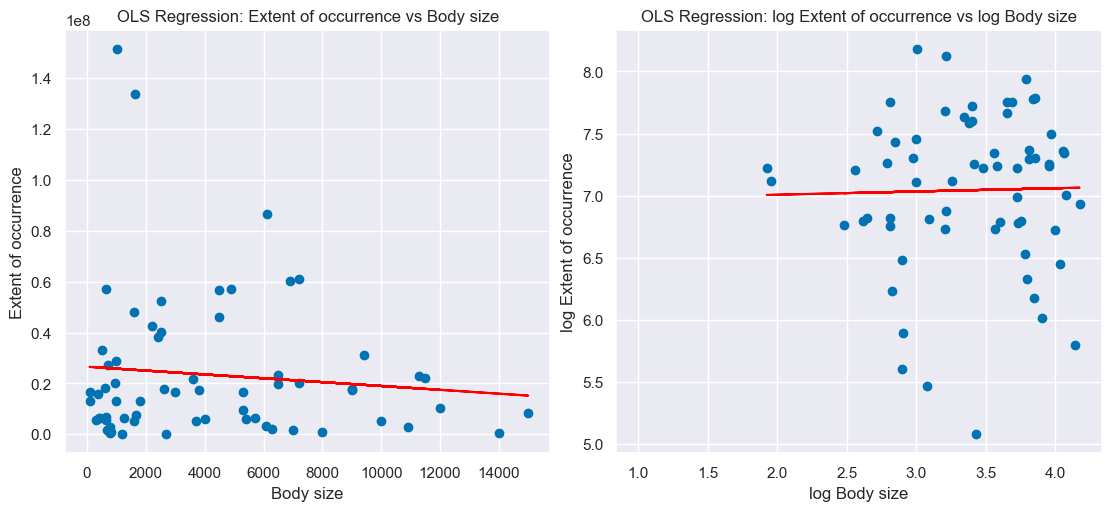

In [145]:
# Define the equations of my lines
ols_line_equation = 2.657e07 + (-756.5066 * x)
log_ols_line_equation = 6.9554 + (0.0261 * log_x)

fig, axs = plt.subplots(1, 2, figsize=(11, 5), layout="constrained")

# First subplot: Extent of occurrence vs Body size
axs[0].scatter(scavengers["Body size"], scavengers["Extent of occurrence"])
axs[0].plot(
    x,
    ols_line_equation,
    color="red",
)
axs[0].set_xlabel("Body size")
axs[0].set_ylabel("Extent of occurrence")
axs[0].set_title("OLS Regression: Extent of occurrence vs Body size")

# Second subplot: log Extent of occurrence vs log Body size
axs[1].scatter(scavengers["log Body size"], scavengers["log Extent of occurrence"])
axs[1].plot(
    log_x,
    log_ols_line_equation,
    color="red",
)
axs[1].set_xlabel("log Body size")
axs[1].set_ylabel("log Extent of occurrence")
axs[1].set_title("OLS Regression: log Extent of occurrence vs log Body size")

plt.show()

<a id='4.1.2'></a>
### 4.1.2 Residuals distribution

The Jarque-Bera test statistic from the model summary is quite large (9.479) and indicates that the residuals are not normally distributed, and the small Jarque-Bera p-value (p < 0.00874) says that there is a low probability of sampling from a normal distribution.

However, the Jarque-Bera test is better suited for larger sample sizes ([SciPy User Guide, Jarque-Bera goodness of fit test](https://docs.scipy.org/doc/scipy/tutorial/stats/hypothesis_jarque_bera.html#hypothesis-jarque-bera)), so let's assess the normality of the residuals with basic descriptive statistics and visualization.

In [160]:
ols_residuals = ols_model.resid
log_ols_residuals = log_ols_model.resid

# Rather than printing with f'strings, make a table for readability
residuals_df = pd.DataFrame({
    "OLS residuals": ols_residuals.describe(),
    "Log OLS residuals": log_ols_residuals.describe()
})
# NB: the 50th percentile is the same as the median

display(residuals_df)

,OLS residuals,Log OLS residuals
count,6.500000e+01,6.500000e+01
mean,4.584973e-10,-1.639714e-15
std,2.856703e+07,6.354159e-01
min,-2.557115e+07,-1.963329e+00
25%,-1.857916e+07,-2.701634e-01
50%,-7.685494e+06,1.744652e-01
75%,4.781587e+06,4.232809e-01
max,1.257176e+08,1.146722e+00


OLS box plot

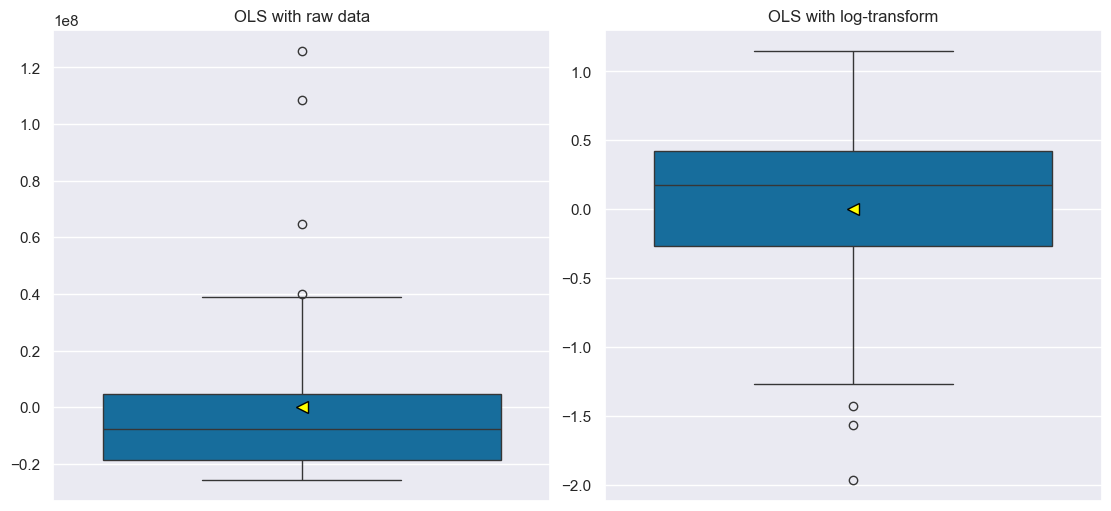

In [162]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(11,5), layout="constrained")

sns.boxplot(
    ols_residuals,
    ax=ax1,
    showmeans=True, # Place a marker where the mean lies
    meanprops={
        "marker": "<",
        "markerfacecolor": "yellow",
        "markeredgecolor": "black",
        "markersize": "8",
    }
)
sns.boxplot(
    log_ols_residuals,
    ax=ax2,
    showmeans=True,
    meanprops={
        "marker": "<",
        "markerfacecolor": "yellow",
        "markeredgecolor": "black",
        "markersize": "8",
    },
)
ax1.set_title("OLS with raw data")
ax2.set_title("OLS with log-transform")
plt.show()

The residuals are right-skewed without the log-transformation, because the mean ($5\cdot10^{-10}$) is greater than the median ($-8\cdot10^6$) and the median is closer to the bottom of the plot (Bobbit, 2021).
The model would therefore be a good candidate for being log-transformed, shown on the right with more normally distributed residuals and also fewer potential outliers, so this may indeed be the better model.

Since the model seems to do better with a log transformation, I will check the residuals plot and Q-Q plot for `log_old_model` and investigate these potential outliers.

<!-- ; however, with a sample size of 65, I want to avoid making it even smaller by removing data, so let's look further into those three values. -->

Residuals plot

Note: I used Copilot to help me with the residuals plot when the built-in functions from Statsmodels and Seaborn kept plotting the actual data and residuals, rather than the predicted values and residuals.

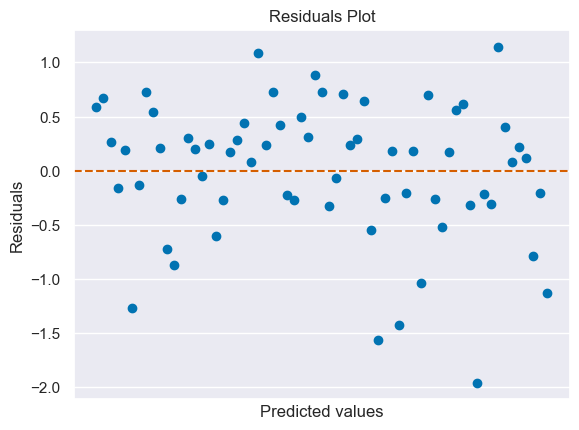

In [166]:
plt.plot(log_ols_residuals, "o")
plt.axhline(y=0, color="r", linestyle="--")
plt.xticks([])
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

QQ plot

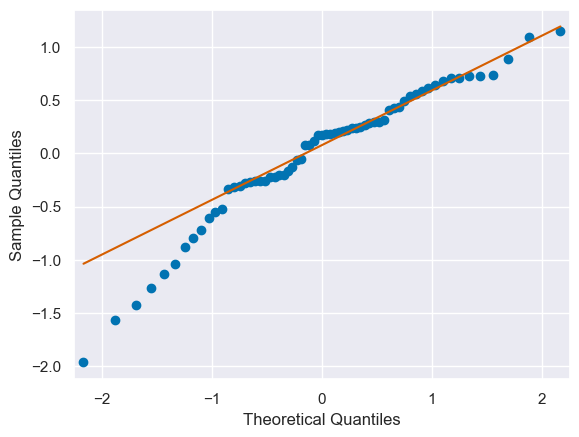

In [170]:
# Include a line fit through the quartiles
sm.qqplot(log_ols_residuals, line="q")
plt.show()

The residuals plot doesn't look too bad, though there may be an impact on the distribution through the lowermost values.
The Q-Q plot is also not too bad, though there is a fair amount of departure from the quartiles line with the lower values, which may be due to those outliers shown in the box plot.
<!-- with the negative residual values indicating that the predicted values are too high relative to the actual values (Wijaya, 2025). -->
<!-- The Q-Q plot, histogram, and Shapiro-Wilk test (0.95, p-value = 0.007) show that our residuals violate the assumption that the residuals are normally distributed (Zdaniuk, 2014), and further exhibit the skew of the data. -->
It's possible that when scavengers are examined as a single group there is not a linear relationship, not even one that can be teased out with a logarithmic transformation.
This would align with what Blackburn and Gaston (1996) found with their study on New World birds.
I could remove those observations, but I'm hesitant to delete data when the sample size is already small.
Instead, let's try to manage the outliers.

<!-- Instead, I can try other tests more suitable for skewed data. -->

<a id='4.1.2'></a>
### Outlier management

In [165]:
log_ols_model.outlier_test()

,student_resid,unadj_p,bonf(p)
Black vulture,0.922207,0.359995,1.0
Turkey vulture,1.062180,0.292274,1.0
Lesser yellow headed vulture,0.420394,0.675651,1.0
Greater yellow headed vulture,-0.258441,0.796923,1.0
King vulture,0.299497,0.765562,1.0
...,...,...,...
Canada jay,0.364985,0.716365,1.0
Siberian jay,0.190990,0.849157,1.0
Chihuahua raven,-1.266245,0.210162,1.0
Torresian crow,-0.328473,0.743661,1.0


The `outlier_test` indicates that I do not have any outliers, but since they are showing up on the boxplot and seem to be having an impact in the other residuals I am not convinced of this test.
This is veering into unfamiliar territory for me, so I used Copilot for assistance.
It suggested looking for values with high studentized residuals in this situation.

In [171]:
outlier_test_results = log_ols_model.outlier_test()

# Identify observations with high studentized residuals beyond ±2
high_residuals = outlier_test_results[abs(outlier_test_results['student_resid']) > 2]

print("Observations with high studentized residuals:")
print(high_residuals)

Observations with high studentized residuals:
                         student_resid   unadj_p   bonf(p)
California condor            -2.082984  0.041383  1.000000
Striated caracara            -2.583360  0.012156  0.790150
White-throated caracara      -2.340503  0.022490  1.000000
Sanford's sea eagle          -3.327544  0.001477  0.096008


The Striated caracara and Sanford's sea eagle are significant outliers after Bonferroni adjustments, shown by values deviating from 1.

<!-- The high studentized residuals for the non-transformed `OLS` show that the Common raven and Black kite are outliers:

| Species | student_resid | unadj_p | bonf(p) |
|---------|---------------|---------|---------| 
|Common raven  |     4.317678 | 0.000058 | 0.003762 |
|Golden eagle  |     2.341806 | 0.022418 | 1.000000 |
|Black kite    |     5.286957 | 0.000002 | 0.000111 | -->

Rather than deleting these observations, I'll instead use robust regression to make my models less sensitive to outliers. I chose to use Statsmodel's `RLM` function, because it uses the same iteratively reweighted least squares method that `GLM` does for maximum likelihood estimation, allowing me to compare them with an AIC later. `RLM` uses Huber's T by default to diminish outliers ([Robust Linear Models - statsmodels 0.14.4](https://www.statsmodels.org/stable/rlm.html)).

In [174]:
rlm_results = sm.RLM(log_y, log_x).fit()
rlm_residuals = rlm_results.resid

print(rlm_results.summary())

                       Robust linear Model Regression Results                       
Dep. Variable:     log Extent of occurrence   No. Observations:                   65
Model:                                  RLM   Df Residuals:                       63
Method:                                IRLS   Df Model:                            1
Norm:                                HuberT                                         
Scale Est.:                             mad                                         
Cov Type:                                H1                                         
Date:                      Thu, 24 Apr 2025                                         
Time:                              21:38:35                                         
No. Iterations:                          14                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

Boxplot

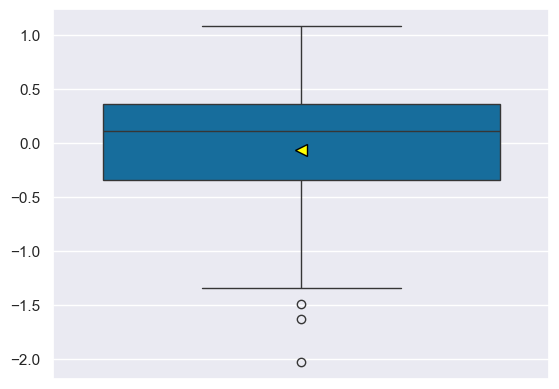

In [177]:
sns.boxplot(
    rlm_residuals,
    showmeans=True,
    meanprops={
        "marker": "<",
        "markerfacecolor": "yellow",
        "markeredgecolor": "black",
        "markersize": "8",
    },
)
plt.show()

De-weighting the outliers in the robust linear model had a negligible effect, with the line still at $7+0.03x_i$ after rounding, and p-value = 0.809 instead of 0.863.

Without further analyses beyond the scope of this term project, I cannot find a compelling relationship between body size and EOO for global avian scavengers.

<a id='4.2'></a>
## 4.2 Obligate and facultative scavengers

Now we want to determine whether there is a difference in the relationship between body size and range size between obligate and facultative scavengers that can be attributed to diet.
We will do this by categorizing the birds as obligate or facultative carrion feeders and including an interaction term in our regression, allowing the two groups to have their own intercepts and slopes (Greenwood, 2025).
Adding an interaction term will make the linear equation look like:

$$
\begin{equation}
    y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_{12}x_1x_2 + \epsilon \tag{2}
\end{equation}
$$

We have two predictor variables, $x_1$ and $x_2$, for body size and diet. The first is quantitative data and the latter is categorical, which we can have Statsmodels convert into numerical values by arbitrarily assigning a baseline group = 0 and the other = 1, sometimes referred to as dummy variables [CITATIONS].

<!-- The baseline group simplifies the equation to the regular linear regression equation we know and love, and when  -->

<!-- where $\beta_{12}x_1x_2$ can be simplified to $\beta_3x_3$. -->

I could not find a nice way to do this with Statsmodels, so I got help from Copilot and imported Statsmodel's formulas API, which may look a little familiar to R users.

In [189]:
# Create new columns with spaceless names. I prefer camel case for screen reader reasons.
scavengers["logExtentOfOccurrence"] = scavengers["log Extent of occurrence"]
scavengers["logBodySize"] = scavengers["log Body size"]

formula = "logExtentOfOccurrence ~ logBodySize + Diet + logBodySize:Diet"
# NB: this is the same as writing "logExtentOfOccurrence ~ logBodySize * Diet", but I chose to write it like this to make the connection with Equation 2 more clear.

interaction_ols = smf.ols(formula=formula, data=scavengers).fit()
print(interaction_ols.summary())

                              OLS Regression Results                             
Dep. Variable:     logExtentOfOccurrence   R-squared:                       0.036
Model:                               OLS   Adj. R-squared:                 -0.012
Method:                    Least Squares   F-statistic:                    0.7522
Date:                   Thu, 24 Apr 2025   Prob (F-statistic):              0.525
Time:                           22:12:19   Log-Likelihood:                -61.086
No. Observations:                     65   AIC:                             130.2
Df Residuals:                         61   BIC:                             138.9
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

<a id='4.2.1'></a>
### 4.2.1 Model plot

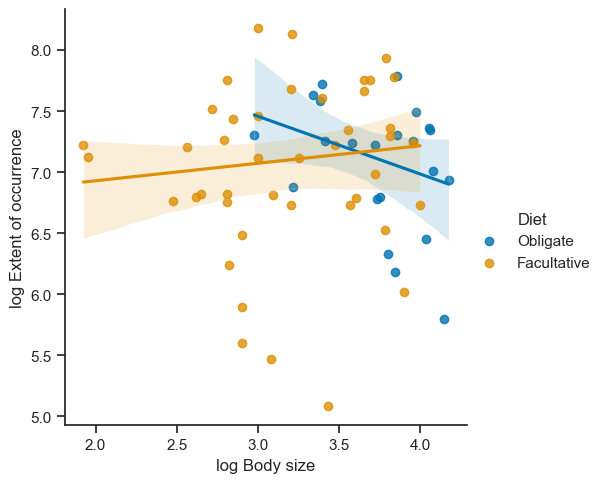

In [25]:
sns.lmplot(
    x="log Body size",
    y="log Extent of occurrence",
    data=scavengers,
    hue="Diet",
    scatter=True,
    robust=True,  # De-weights outliers
)
plt.show()

<a id='4.2.2'></a>
### 4.2.2 Residuals distribution

In [26]:
# Extract coefficients from the model
intercept = interaction_ols.params["Intercept"]
diet_obligate_coef = interaction_ols.params["Diet[T.Obligate]"]
log_body_coef = interaction_ols.params["logBodySize"]
interaction_coef = interaction_ols.params["logBodySize:Diet[T.Obligate]"]
interaction_residuals = interaction_ols.resid

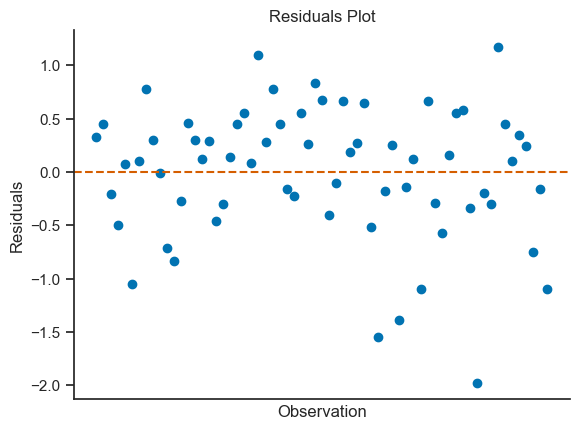

In [27]:
plt.plot(interaction_residuals, "o")
plt.axhline(y=0, color="r", linestyle="--")
plt.xticks([])
plt.xlabel("Observation")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

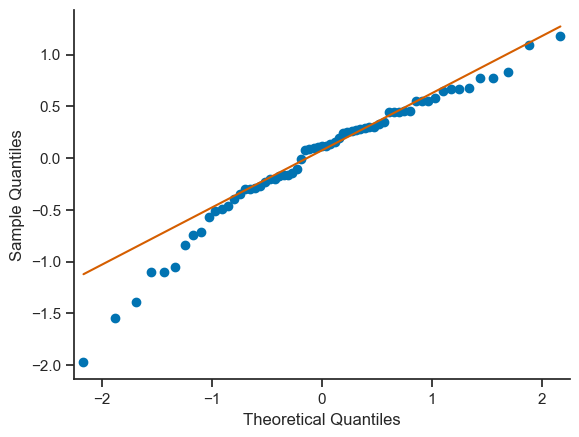

In [28]:
sm.qqplot(interaction_residuals, line="q")
plt.show()

<Axes: ylabel='Count'>

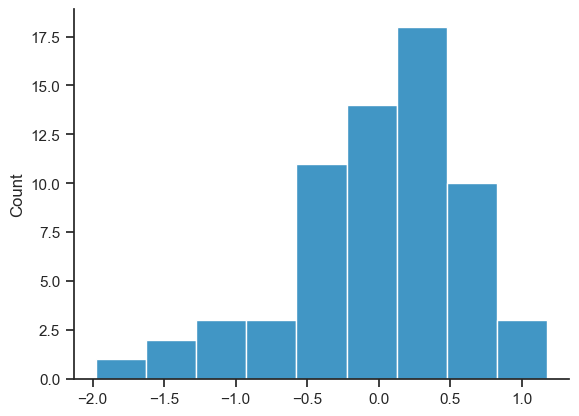

In [29]:
sns.histplot(interaction_residuals)

In [30]:
interaction_shapiro = stats.shapiro(interaction_residuals)

print(
    f"Diet interaction Shapiro-Wilk test:\nStatistic: {interaction_shapiro.statistic:.2f}, p-value: {interaction_shapiro.pvalue:.5f}"
)

Diet interaction Shapiro-Wilk test:
Statistic: 0.95, p-value: 0.01722


<a id='5'></a>
# 5. Significance

* Highlights the importance of scale in macroecological research. What we already recognize in macroecology of that "rule" in macroecology of larger body sizes means larger range sizes and that diff patterns can be viewed at different scales, and the further we break down relationships between taxa the more the "rule" of BSRS disintegrates.
* Looks at that rule of BSRS [cite Brown and Maurer 1989] and looks at how that rule breaks down as we change the taxonomic scale under consideration.

<a id='6'></a>
# 6. References

BirdLife International (2024). IUCN Red List for birds. Last visited 2025-03-14. https://datazone.birdlife.org/

<!-- Bobbit, Z. (2021) Left Skewed vs. Right Skewed Distributions. Statology. https://www.statology.org/left-skewed-vs-right-skewed/ -->

Ferguson-Lees, J. & Christie, D. A. (2005) Raptors of the world. Princeton NJ: Princeton University Press.

Greenwood, M. (2025). 8.11: Different slopes and different intercepts. In: Intermediate Statistics with R. LibreTexts. [https://stats.libretexts.org/Bookshelves/Advanced_Statistics/Intermediate_Statistics_with_R_(Greenwood)/08%3A_Multiple_linear_regression/8.11%3A_Different_slopes_and_different_intercepts](https://stats.libretexts.org/Bookshelves/Advanced_Statistics/Intermediate_Statistics_with_R_(Greenwood)/08%3A_Multiple_linear_regression/8.11%3A_Different_slopes_and_different_intercepts)

James H. Brown, Brian A. Maurer (1989). Macroecology: The Division of Food and Space Among Species on Continents. Science *243*, 1145-1150. [DOI:10.1126/science.243.4895.1145](https://doi.org/10.1126/science.243.4895.1145).

M. C. K. Tweedie "Statistical Properties of Inverse Gaussian Distributions. I," The Annals of Mathematical Statistics, Ann. Math. Statist. 28(2), 362-377, (June, 1957) https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-28/issue-2/Statistical-Properties-of-Inverse-Gaussian-Distributions-I/10.1214/aoms/1177706964.full

Wijaya, C.Y. (2025). Understanding Residual Plots. Statology. https://www.statology.org/understanding-residual-plots/

<!-- Ongko, G. (2022). Iterated Reweighted Least Squares and GLMs Explained. Towards Data Science. https://towardsdatascience.com/iterated-reweighted-least-squares-and-glms-explained-9c0cc0063526/ -->

Zdaniuk, B. (2014). Ordinary Least-Squares (OLS) Model. In: Michalos, A.C. (eds) Encyclopedia of Quality of Life and Well-Being Research. Springer, Dordrecht. https://doi-org.ezproxy.library.uvic.ca/10.1007/978-94-007-0753-5_2008